In [85]:
# IMPORTAMOS LAS LIBREARIAS A USAR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score
import joblib
from imblearn.over_sampling import RandomOverSampler

In [86]:
# Cargar los datos desde un archivo CSV con el delimitador "|"
df = pd.read_csv('20230630_BASE_JUNIO_CENCOSUD_TC_TOTAL.csv', delimiter='|')
print(df.shape)

(195473, 15)


In [87]:
df

,FLG_CLIENTE_NUEVO,RECURRENCIA,QUINTIL_PROPENSION,LINEA_CENCOSUD,RNG_LINEA_CENCOSUD,NUM_TC,RNG_EDAD,REGIMEN_LABORAL,SEG_CONTACT,SEGMENTO,TIPO_TARJETA_CENCO,IDCLIENTE,CLTS,CLTS_CET,CLTS_VTA_REAL
0,1,1,4,2500,D,2,F,INFOR,C1,TC3,CLASICA,3465978,1,0,0
1,1,1,4,4000,E,1,F,INDEP,C1,TC3,CLASICA,3893451,1,0,0
2,1,1,4,2500,D,0,F,INDEP,C1,TC3,CLASICA,4006770,1,1,0
3,1,1,4,1000,C,0,E,INDEP,C1,TC3,CLASICA,3325874,1,0,0
4,1,1,4,1000,C,0,E,DEP,C1,TC3,CLASICA,2882542,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195468,1,1,5,1000,C,0,D,INFOR,C3,TC3,CLASICA,80541101,1,1,0
195469,1,0,5,1000,C,0,D,INFOR,C3,TC3,CLASICA,80404893,1,1,0
195470,0,0,1,3000,D,0,D,INDEP,C1,TC2,CLASICA,80592574,1,1,0
195471,0,0,1,3000,D,3,D,INDEP,C1,TC2,CLASICA,80607151,1,1,0


In [88]:
df = df.drop('RNG_LINEA_CENCOSUD', axis=1)

In [89]:
# Crear una lista para almacenar los valores modificados
nueva_columna = []

# Aplicar la condición y agregar los valores de rangos
for valor in df['LINEA_CENCOSUD']:
    if valor > 490 and valor < 1110:
        nueva_columna.append('C')
    elif valor > 1110 and valor < 3110:
        nueva_columna.append('D')
    elif valor > 3110 and valor < 6110:
        nueva_columna.append('E')
    elif valor > 6110 and valor < 10110:
        nueva_columna.append('F')
    elif valor > 10110:
        nueva_columna.append('G')
    else:
        print("Hay valores fuera del rango")

# Agregar la lista como una nueva columna en el DataFrame
df['RNG_LINEA_CENCOSUD'] = nueva_columna

In [90]:
# Extraer la columna que deseas mover
columna_a_mover = df.pop('RNG_LINEA_CENCOSUD')

# Insertar la columna extraída al costado de la columna 'A'
df.insert(loc=df.columns.get_loc('LINEA_CENCOSUD')+1, column='RNG_LINEA_CENCOSUD', value=columna_a_mover)

In [91]:
# Calcular el valor mínimo y máximo de linea cencosud
min_precios = df.groupby('RNG_LINEA_CENCOSUD')['LINEA_CENCOSUD'].min()
max_precios = df.groupby('RNG_LINEA_CENCOSUD')['LINEA_CENCOSUD'].max()

# Imprimir los resultados
print("Valor mínimo de precios por rango:")
print(min_precios)
print("\nValor máximo de precios por rango:")
print(max_precios)

Valor mínimo de precios por rango:
RNG_LINEA_CENCOSUD
C      500
D     1200
E     3200
F     6200
G    10200
Name: LINEA_CENCOSUD, dtype: int64

Valor máximo de precios por rango:
RNG_LINEA_CENCOSUD
C     1100
D     3100
E     6100
F    10100
G    15000
Name: LINEA_CENCOSUD, dtype: int64


In [94]:
df["SEG_CONTACT"].value_counts()

C2    90005
C3    54850
C1    50582
Name: SEG_CONTACT, dtype: int64

In [93]:
# Eliminar las filas con valor x en la columna A
valor_x = 'WTF'
df = df.drop(df[df['SEG_CONTACT'] == valor_x].index)

In [95]:
# Eliminar duplicados basados en una columna específica
df = df.drop_duplicates(subset=['IDCLIENTE'])

In [96]:
data = df.copy()

In [97]:
# Eliminamos columnas que solo tienen una variable o datos innecesarios para el modelo de prediccion

data = data.drop('CLTS', axis=1)
#data = data.drop('CLTS_CET', axis=1)
#data = data.drop('IDCLIENTE', axis=1)

In [98]:
data.shape

(195437, 14)

In [99]:
new_data= data.copy()

In [100]:
# Lista de columnas categóricas a codificar
columnas_categoricas = ['RNG_LINEA_CENCOSUD', 'RNG_EDAD', 'REGIMEN_LABORAL', 'SEG_CONTACT', 'SEGMENTO', 'TIPO_TARJETA_CENCO']

# DataFrame con las columnas numéricas originales
df_numerico = new_data.drop(columnas_categoricas, axis=1)

# Aplicar one-hot encoding solo a las columnas categóricas
df_codificado = pd.get_dummies(new_data[columnas_categoricas], drop_first=True)
df_codificado = df_codificado.replace({True: 1, False: 0})

# Combinar el DataFrame codificado con las columnas numéricas originales
df_final = pd.concat([df_numerico, df_codificado], axis=1)

In [101]:
df_final

,FLG_CLIENTE_NUEVO,RECURRENCIA,QUINTIL_PROPENSION,LINEA_CENCOSUD,NUM_TC,IDCLIENTE,CLTS_CET,CLTS_VTA_REAL,RNG_LINEA_CENCOSUD_D,RNG_LINEA_CENCOSUD_E,...,RNG_EDAD_F,RNG_EDAD_G,RNG_EDAD_Z,REGIMEN_LABORAL_INDEP,REGIMEN_LABORAL_INFOR,SEG_CONTACT_C2,SEG_CONTACT_C3,SEGMENTO_TC2,SEGMENTO_TC3,TIPO_TARJETA_CENCO_CLASICA
0,1,1,4,2500,2,3465978,0,0,1,0,...,1,0,0,0,1,0,0,0,1,1
1,1,1,4,4000,1,3893451,0,0,0,1,...,1,0,0,1,0,0,0,0,1,1
2,1,1,4,2500,0,4006770,1,0,1,0,...,1,0,0,1,0,0,0,0,1,1
3,1,1,4,1000,0,3325874,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,1,1,4,1000,0,2882542,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195468,1,1,5,1000,0,80541101,1,0,0,0,...,0,0,0,0,1,0,1,0,1,1
195469,1,0,5,1000,0,80404893,1,0,0,0,...,0,0,0,0,1,0,1,0,1,1
195470,0,0,1,3000,0,80592574,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
195471,0,0,1,3000,3,80607151,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1


In [102]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195437 entries, 0 to 195472
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   FLG_CLIENTE_NUEVO           195437 non-null  int64
 1   RECURRENCIA                 195437 non-null  int64
 2   QUINTIL_PROPENSION          195437 non-null  int64
 3   LINEA_CENCOSUD              195437 non-null  int64
 4   NUM_TC                      195437 non-null  int64
 5   IDCLIENTE                   195437 non-null  int64
 6   CLTS_CET                    195437 non-null  int64
 7   CLTS_VTA_REAL               195437 non-null  int64
 8   RNG_LINEA_CENCOSUD_D        195437 non-null  uint8
 9   RNG_LINEA_CENCOSUD_E        195437 non-null  uint8
 10  RNG_LINEA_CENCOSUD_F        195437 non-null  uint8
 11  RNG_LINEA_CENCOSUD_G        195437 non-null  uint8
 12  RNG_EDAD_B                  195437 non-null  uint8
 13  RNG_EDAD_C                  195437 non-null 

In [103]:
# Cargar el modelo entrenado desde el archivo
model_LR = joblib.load('modelo_LR.pkl')
model_LGB =joblib.load('modelo_LGB.pkl')
model_XGB =joblib.load('modelo_XGB.pkl')
model_ensamble = joblib.load('ENSAMBLE.pkl')

# Cargar la nueva base de datos
df_nueva_base = df_final

# Obtener las características (X) de la nueva base de datos
X_nueva_base = df_nueva_base.drop('CLTS_VTA_REAL', axis=1)
Y_nueva_base = df_nueva_base['CLTS_VTA_REAL']

In [105]:
# from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import RobustScaler

In [106]:
# Crear un objeto RobustScaler
scaler = RobustScaler()

# Ajustar el scaler con los datos de la nueva base de datos
scaler.fit(X_nueva_base)

# Aplicar el scaler a los nuevos datos
X_nueva_base = scaler.transform(X_nueva_base)

In [107]:
# oversampler = RandomOverSampler(random_state=42)
# X_nueva_base_resampled, y_nueva_base_resampled = oversampler.fit_resample(X_nueva_base, Y_nueva_base)

In [113]:
# Asignar nombres genéricos a las columnas del DataFrame
#nombres_caracteristicas = [f'Caracteristica_{i+1}' for i in range(X_nueva_base.shape[1])]
#X_nueva_base.columns = nombres_caracteristicas

# Realizar las predicciones utilizando el modelo cargado
predicciones_LR = model_LR.predict(X_nueva_base)

In [115]:
predicciones_LR

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [116]:
## si queremos los datos en un df para luego hacer un join con los datos base
#df_predicciones = pd.DataFrame(predicciones_LR, columns=['Predicciones'])


Reporte de métricas Regresión Logística: 
               precision    recall  f1-score   support

           0       1.00      0.86      0.93    194549
           1       0.03      0.96      0.06       888

    accuracy                           0.86    195437
   macro avg       0.52      0.91      0.49    195437
weighted avg       1.00      0.86      0.92    195437

Matriz de Confusión:
 [[167978  26571]
 [    32    856]]


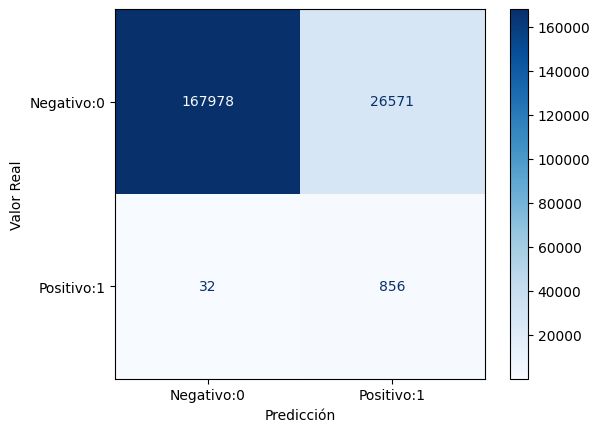

In [119]:
y_preds = model_LR.predict(X_nueva_base)
print("Reporte de métricas Regresión Logística: \n", classification_report(Y_nueva_base, y_preds, zero_division=1))

matriz = confusion_matrix(Y_nueva_base, y_preds)
print('Matriz de Confusión:\n', matriz)

mc = confusion_matrix(Y_nueva_base, y_preds)
cm_display = ConfusionMatrixDisplay(mc, display_labels=["Negativo:0", "Positivo:1"])
cm_display.plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Predicción")
cm_display.ax_.set_ylabel("Valor Real")
plt.show()

In [121]:
# Realizar las predicciones utilizando el modelo cargado
predicciones_LGB = model_LGB.predict(X_nueva_base)

Reporte de métricas Regresión Logística: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    194549
           1       0.05      0.40      0.08       888

    accuracy                           0.96    195437
   macro avg       0.52      0.68      0.53    195437
weighted avg       0.99      0.96      0.97    195437

Matriz de Confusión:
 [[187065   7484]
 [   529    359]]


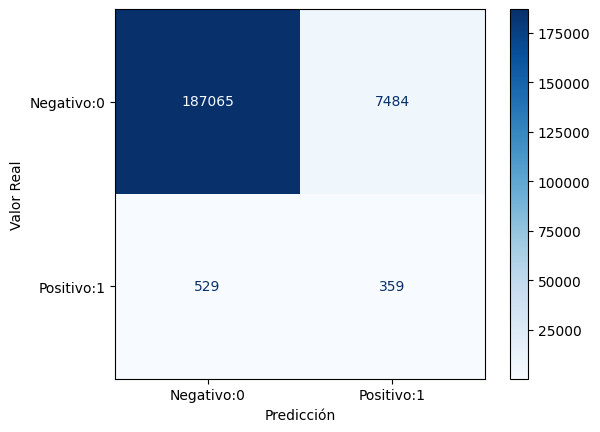

In [122]:
y_preds = model_LGB.predict(X_nueva_base)
print("Reporte de métricas Regresión Logística: \n", classification_report(Y_nueva_base, y_preds, zero_division=1))

matriz = confusion_matrix(Y_nueva_base, y_preds)
print('Matriz de Confusión:\n', matriz)

mc = confusion_matrix(Y_nueva_base, y_preds)
cm_display = ConfusionMatrixDisplay(mc, display_labels=["Negativo:0", "Positivo:1"])
cm_display.plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Predicción")
cm_display.ax_.set_ylabel("Valor Real")
plt.show()

In [123]:
# Realizar las predicciones utilizando el modelo cargado
predicciones_XGB = model_XGB.predict(X_nueva_base)

Reporte de métricas Regresión Logística: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    194549
           1       0.04      0.44      0.08       888

    accuracy                           0.95    195437
   macro avg       0.52      0.70      0.53    195437
weighted avg       0.99      0.95      0.97    195437

Matriz de Confusión:
 [[185744   8805]
 [   501    387]]


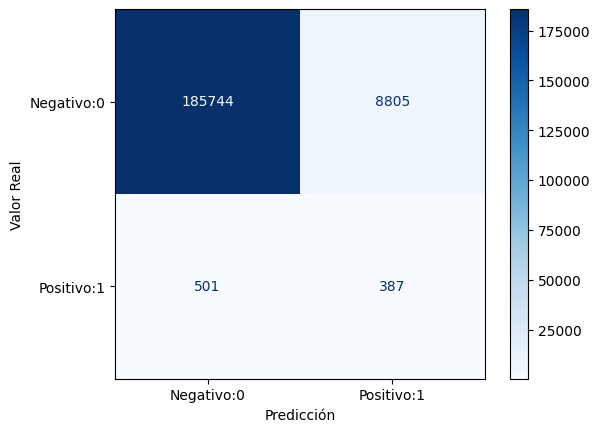

In [124]:
y_preds = model_XGB.predict(X_nueva_base)
print("Reporte de métricas Regresión Logística: \n", classification_report(Y_nueva_base, y_preds, zero_division=1))

matriz = confusion_matrix(Y_nueva_base, y_preds)
print('Matriz de Confusión:\n', matriz)

mc = confusion_matrix(Y_nueva_base, y_preds)
cm_display = ConfusionMatrixDisplay(mc, display_labels=["Negativo:0", "Positivo:1"])
cm_display.plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Predicción")
cm_display.ax_.set_ylabel("Valor Real")
plt.show()

In [125]:
# Realizar las predicciones utilizando el modelo cargado
predicciones_ENSAMBLE = model_ensamble.predict(X_nueva_base)

Reporte de métricas Regresión Logística: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    194549
           1       0.05      0.33      0.09       888

    accuracy                           0.97    195437
   macro avg       0.52      0.65      0.54    195437
weighted avg       0.99      0.97      0.98    195437

Matriz de Confusión:
 [[189188   5361]
 [   592    296]]


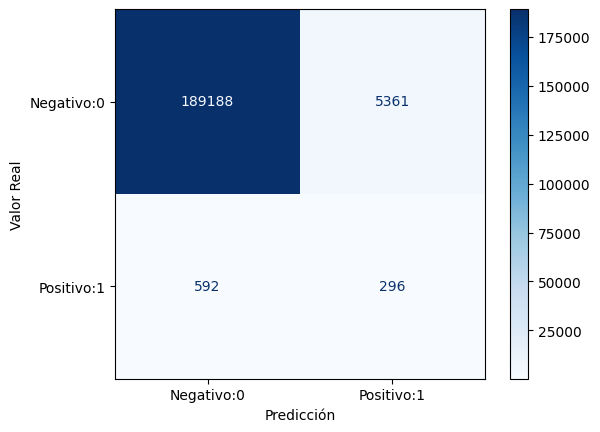

In [126]:
y_preds = model_ensamble.predict(X_nueva_base)
print("Reporte de métricas Regresión Logística: \n", classification_report(Y_nueva_base, y_preds, zero_division=1))

matriz = confusion_matrix(Y_nueva_base, y_preds)
print('Matriz de Confusión:\n', matriz)

mc = confusion_matrix(Y_nueva_base, y_preds)
cm_display = ConfusionMatrixDisplay(mc, display_labels=["Negativo:0", "Positivo:1"])
cm_display.plot(cmap=plt.cm.Blues)
cm_display.ax_.set_xlabel("Predicción")
cm_display.ax_.set_ylabel("Valor Real")
plt.show()

Los modelos siempre varian de acuerdo a los datos que se tiene como base de datos, mientras mejor sea nuestra base de datos mejor sera el modelo, en este proyecto se concluye al cargar el modelo base y hacer el etl correspondiente a la base de datos, el mejor modelo en el cual hay mas acierto en verdaderos positivos es el modelo de LR ( logistica regresion), de igual manera no se puede descartar los otros modelos ya que en el modelo base obtuvo una mejor puntuacion.